In [36]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer#, NewtonOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Abstract

In this blog post, I created an implementation of the logistic regression classification model, and performed some experiments using it to confirm its functioning. First, I used it to perform 'vanilla' gradient descent, wherein I set its learning rate $\beta = 0$. I then performed gradient descent with momentum (when the value of $\beta$ is $> 0$), and observed a speed-up in loss minimization within my model. Finally, I trained my model on classification data with a greater number of features than data points, and observed the issue of overfitting, wherein the model's accuracy is extremely high with the training data, but far more inaccurate when tested against new data.

# Part A: Implement Logistic Regression

Here is a link to my [logistic.py](https://github.com/opfleet/opfleet.github.io/blob/main/posts/LogisticPost/logistic.py) file, which contains my documented implementation of the logistic regression model that I use throughout this blog post.

# Part B: Experiments

Here is a code chunk to generate arbitrary data with two labels for my logistic regression model to classify throughout my experiments:

In [37]:
import torch

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

### Experiment 1: Vanilla Gradient Descent

**Hypothesis**: When $p_{dim} = 2$, $\alpha$ is sufficiently small, and $\beta = 0$, gradient descent for logistic regression converges to a weight vector **w** that looks visually correct, furthermore, the loss decreases monotonically.

Below I generate data with 2 dimensions using the `classification_data` function I created earlier. I then instantiate a logistic regression model and run a 100-iteration training loop, with $\alpha = 0.1$ and $\beta = 0$. I printed the evolution of loss with each iteration, and it appears to decrease monotonically, but I will confirm this later.

In [38]:
torch.manual_seed(123)
X, y = classification_data(n_points= 500, noise= 0.5, p_dims= 2)

LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)

loss_vec = []
for _ in range(1500):
    local_loss = LR.loss(X, y).item()
    opt.step(X, y, alpha= 0.1, beta= 0.0)
    
    loss_vec.append(local_loss)

print(loss_vec)

[0.5663606524467468, 0.5599420070648193, 0.5537047982215881, 0.5476439595222473, 0.5417548418045044, 0.5360325574874878, 0.5304723978042603, 0.5250697135925293, 0.5198197960853577, 0.5147179961204529, 0.5097599625587463, 0.5049411654472351, 0.5002572536468506, 0.49570396542549133, 0.4912770986557007, 0.4869726002216339, 0.4827864468097687, 0.4787147343158722, 0.4747536778450012, 0.4708996117115021, 0.4671488404273987, 0.46349790692329407, 0.45994341373443604, 0.4564821124076843, 0.4531107544898987, 0.4498262405395508, 0.44662556052207947, 0.44350579380989075, 0.44046422839164734, 0.4374981224536896, 0.43460479378700256, 0.4317817687988281, 0.42902660369873047, 0.42633694410324097, 0.42371055483818054, 0.4211452007293701, 0.41863882541656494, 0.41618937253952026, 0.41379493474960327, 0.41145360469818115, 0.4091636538505554, 0.4069232642650604, 0.40473082661628723, 0.40258467197418213, 0.4004833400249481, 0.39842531085014343, 0.39640918374061584, 0.3944335877895355, 0.3924972116947174, 0

Here I define two useful functions for plotting the decision boundary of my trained logistic regression model: `plot_data` and `draw_line`. These functions come from the Perceptron blog post with slight modifications.

In [39]:
from matplotlib import pyplot as plt

def plot_data(X, y, ax):
    assert X.shape[1] == 3 # when p_dim == 2
    markers = ['o', '^']
    targets = [0, 1]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 40,  c = y[ix]*2-1, facecolors = "none", edgecolors = "darkgrey", cmap = 'seismic', vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 100)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x,y,**kwargs)

Using these two functions, I plot the data points generated by `classification_data`, as well as the decision boundary of the trained logistic regression model (the weight vector of the model after the training loop). The trained model's decision boundary also looks correct, separating the non-linearly separable data quite well.

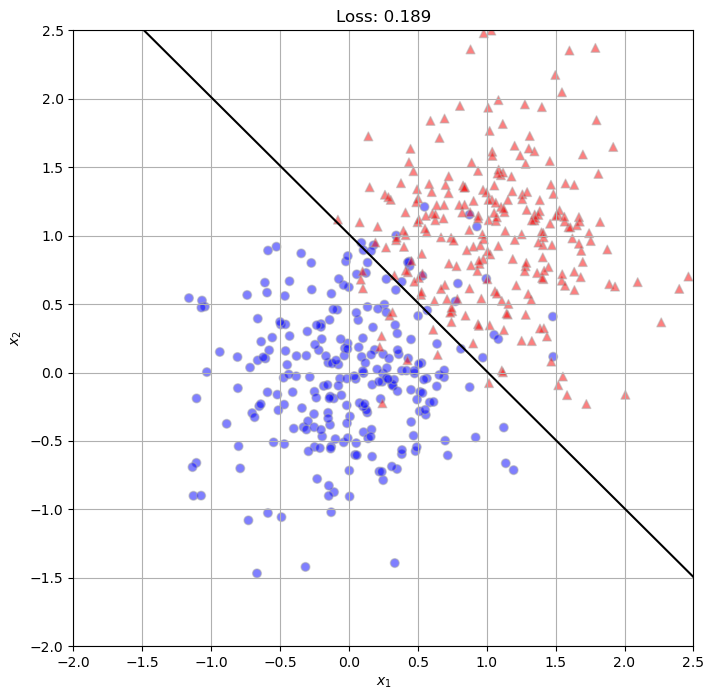

In [40]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.set_xlim([-2, 2.5])
ax.set_ylim([-2, 2.5])

last_loss = loss_vec[len(loss_vec)-1]
ax.set_title(f'Loss: {last_loss:.3f}')
ax.grid(True)

plot_data(X, y, ax)
draw_line(torch.clone(LR.w), -2, 2.5, ax, color= 'black')

In the next visualization, I plot the evolution of the model's loss over each iteration of the training loop. The loss of the model converges at the end of the training process; it seems that the loss converges to a value around 0.17. Again, the loss appears to be monotonically decreasing (every iteration's loss is lower than the previous iteration's), but it is hard to determine towards the end of the training loop.

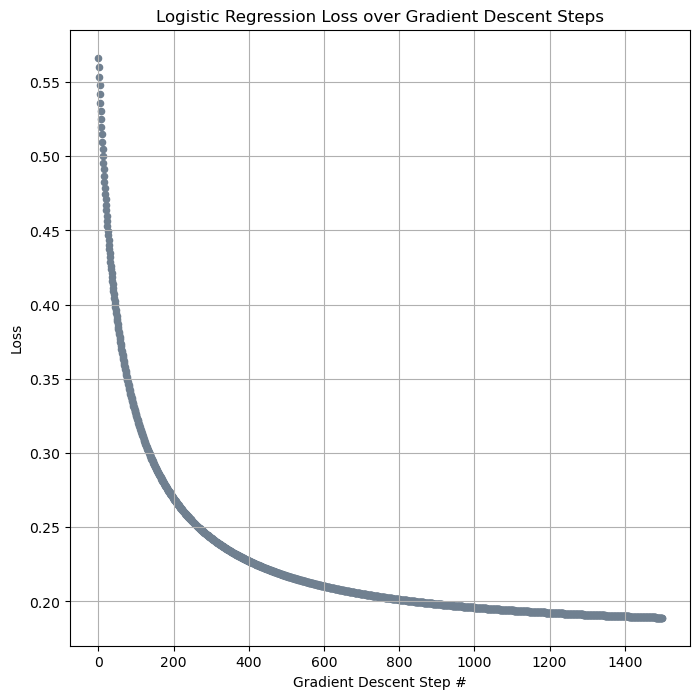

In [41]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.grid(True)
ax.scatter(torch.arange(len(loss_vec)), loss_vec, s = 20, color = "slategrey")
labs = ax.set(xlabel = "Gradient Descent Step #", ylabel = "Loss", title = "Logistic Regression Loss over Gradient Descent Steps")

To confirm that the model's loss is monotonically decreasing, I wrote a quick function `isMonoDecrease` that compares the loss vector to the loss vector sorted in decreasing order. If the vectors are identical, than the model's loss is monotonically decreasing. As can be seen, my model's loss decreases in this fashion.

In [42]:
def isMonoDecrease(v):
    dec = []
    dec.extend(v)
    dec.sort(reverse = True)
    if (v == dec):
        return True
    return False

isMonoDecrease(loss_vec)

True

### Experiment 2: Benefits of Momentum
**Hypothesis**: On the same data, gradient descent with momentum (e.g. $\beta = 0.9$) can converge to the correct weight vector in fewer iterations than vanilla gradient descent (with $\beta = 0$).

Using the same data as the past experiment, I instantiated 9 different logistic regression models in order to experiment with different values for the learning rate $\alpha$. I chose the values 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, and 0.9; I then trained each logistic regression model on the data and used the $\alpha$ value to perform the optimization steps (I opted to run the optimization loop for 100 iterations, to compare the speed up to 'vanilla' gradient descent).

In [43]:
loss_dict = {}
for i in range(1, 10):
    LR = LogisticRegression()
    opt = GradientDescentOptimizer(LR)
    loss_dict[i] = []
    for _ in range(100):
        local_loss = LR.loss(X, y).item()
        opt.step(X, y, alpha= i/10.0, beta= 0.9)
        
        loss_dict[i].append(local_loss)

In the visualization below, I plotted the evolution of loss of the logistic regression models using different $\alpha$ values for the optimization steps. As we can see especially well when considering the logistic regression models using $\alpha$ values of 0.3, 0.6, 0.7, 0.8, and 0.9, the models' loss converge to values comparable to the one seen in the 'vanilla' gradient descent experiment (around 0.2). However, this is achieved in far fewer optimization steps; the model using 'vanilla' gradient descent achieved this loss in 100 optimization steps, while these models using a momentum of $\beta = 0.9$ took only around 10-30 optimization steps. While these plots confirm my hypothesis (that a similar convergence of loss can be achieved in fewer optimization steps than using 'vanilla' gradient descent), there is an issue for when the $\alpha$ value $= 0.1$ that I cannot explain. When $\alpha = 0.1$, it seems that the loss is actually monotonically increasing with every optimization step.

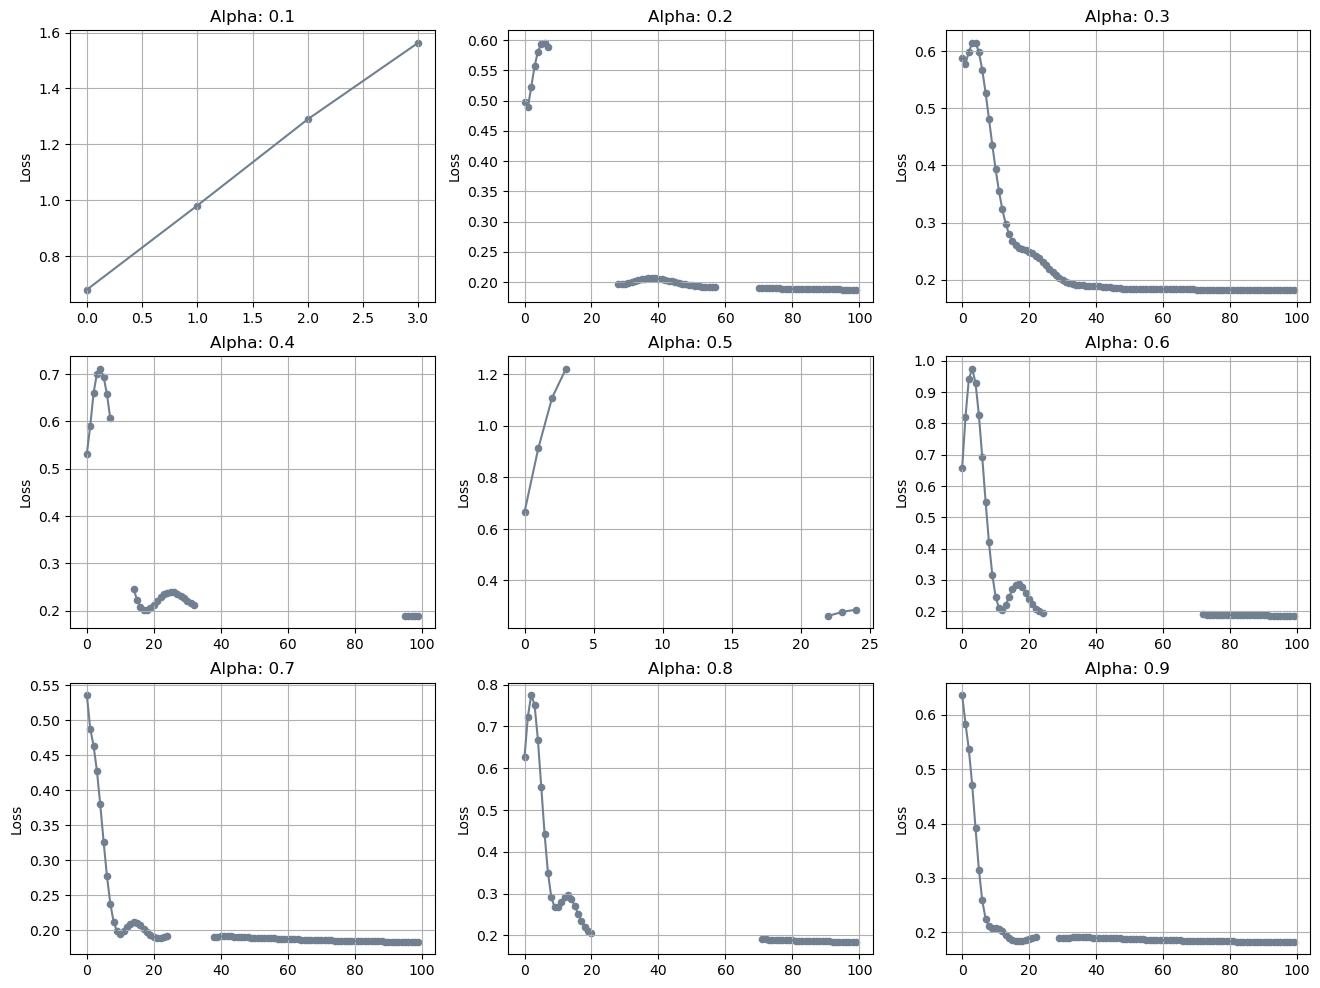

In [44]:
fig, axs = plt.subplots(3, 3, figsize = (16, 12))

for i in range(3):
    for j in range(3):
        axs[i, j].grid(True)
        axs[i, j].plot(loss_dict[i*3+j+1], color = "slategrey")
        axs[i, j].scatter(torch.arange(len(loss_dict[i*3+j+1])), loss_dict[i*3+j+1], s = 20, color = "slategrey")

        labs = axs[i, j].set(ylabel = "Loss", title = f"Alpha: {(i*3+j+1)/10:.1f}")

As the model with an $\alpha$ value of 0.3 was the most continuous, I chose it to compare the evolution of loss of a logistic regression model using gradient descent with momentum against a model that did not use momentum. I plotted the loss of the model that did not use momentum in red, and in green I plotted the loss of the model that did. As can be seen, The model that uses momentum in its gradient descent converged to an acceptable loss value far faster than the model that did not use gradient descent with momentum. (Note: since the model that used gradient descent without momentum trained for 1500 iterations, I shrank the window of the visualization to only plot 200 iterations, so that the difference in loss evolution between the two approaches would be more apparent.)

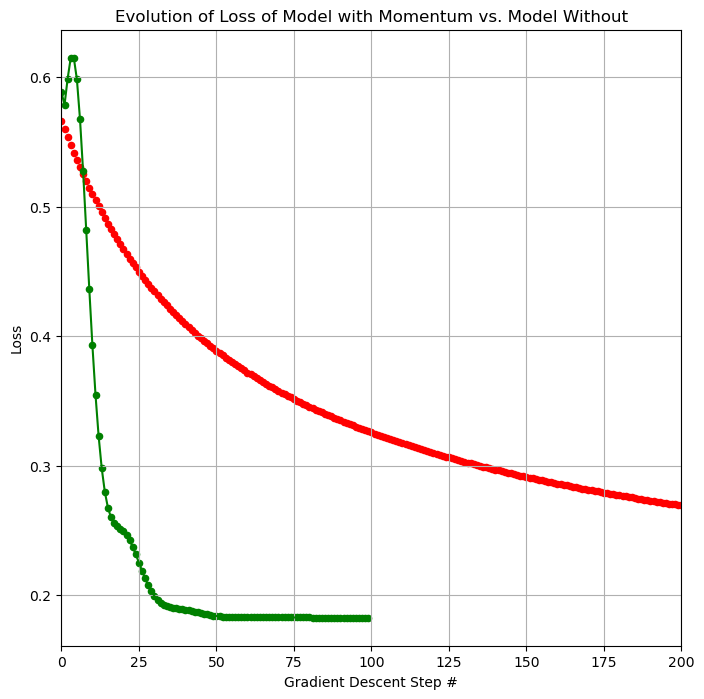

In [45]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.grid(True)
ax.scatter(torch.arange(len(loss_vec)), loss_vec, s = 20, color = "red")
ax.plot(loss_dict[3], color = "green")
ax.scatter(torch.arange(len(loss_dict[3])), loss_dict[3], s = 20, color = "green")
ax.set(xlim= (0,200))
labs = ax.set(xlabel = "Gradient Descent Step #", ylabel = "Loss", title = "Evolution of Loss of Model with Momentum vs. Model Without")

### Experiment 3: Overfitting
**Investigation**: Generate some data where $p_{dim} > n_{points}$. Do this twice with the exact same parameters. Call the first dataset $X\_train$, $y\_train$ and the second dataset $X\_test$, $y\_test$. Then, do an experiment in which you fit a logistic regression model to the data $X\_train$, $y\_train$ and obtain 100% accuracy on this training data. What is the accuracy of the test data?

Below I generated classification data twice using the same parameters ($n_{points} = 5$, $noise = 0.5$, and $p_{dim} = 10$) and labeled them as `X_train` and `y_train` and `X_test` and `y_test`. I then fit a logistic regression model to the data `X_train`, `y_train` until the classification accuracy was 100%.

In [149]:
from sklearn.metrics import accuracy_score
torch.manual_seed(3)

X_train, y_train = classification_data(n_points= 10, noise = 0.2, p_dims= 20)
X_test, y_test = classification_data(n_points= 10, noise = 0.2, p_dims= 20)

X_train = X_train.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)


LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)

loss_vec = []
loss = 1.0
while loss > 0.01:
    loss = LR.loss(X_train, y_train).item()
    opt.step(X_train, y_train, alpha= 0.01, beta= 0.1)
    
    loss_vec.append(loss)

preds_train = LR.predict(X_train)
print(f'Accuracy on train data: {accuracy_score(y_train, preds_train)*100:.2f}%')

Accuracy on train data: 100.00%


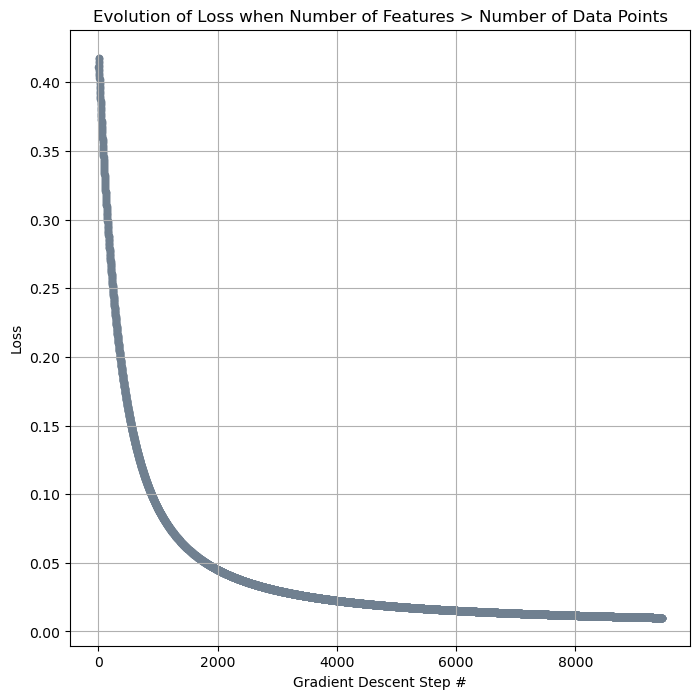

In [150]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.grid(True)

ax.scatter(torch.arange(len(loss_vec)), loss_vec, s = 20, color = "slategrey")
labs = ax.set(xlabel = "Gradient Descent Step #", ylabel = "Loss", title = "Evolution of Loss when Number of Features > Number of Data Points")

I then used the trained model to make predictions based upon the testing data, wherein the accuracy was far lower, around 60%, indicating the model's overfitting to the training data.

In [151]:
#print(f'Loss on test data: {LR.loss(X_test, y_test)*100:.2f}%')

preds_test = LR.predict(X_test)
print(f'Accuracy on test data: {accuracy_score(y_test, preds_test)*100:.2f}%')

Accuracy on test data: 100.00%


# Conclusion

For this blog post, I created an implementation for a logistic regression classification model, and performed three experiments in order to confirm the functionality of my implementation, and to confirm various characteristics of logistic regression models in my implementation. In the first experiment, I performed 'vanilla' gradient descent in the optimization step of my model, and observed the model's weight vector converge to a seemingly correct decision boundary line. I then used gradient descent with momentum in the optimization step of my model, as well as vary the learning rate value for $\alpha$, and observed a substantial speed-up in loss minimization using this momentum. Finally, I performed an experiment where I created training and testing data that my model would be likely to overfit itself upon, and observed the results of a logistic regression model overfitting to the training data.